In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Frame Extraction Cell ---

video_path = 'DynamicHard24.mp4'
frame_indices = [n * 43 for n in range(12)]

extracted_frames = []

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print(f"Error: Could not open video file {video_path}")
else:
    for index in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        if ret:
            extracted_frames.append(frame)
        else:
            print(f"Warning: Could not read frame at index {index}")
    cap.release()

print(f"Extracted {len(extracted_frames)} frames.")

# Global variables to store intermediate results for subsequent cells
processed_edges = []
processed_dilated_inverted = []
processed_contours = []

# Define colors (from your original code)
red = (86, 45, 143)
white = (212, 213, 211)
green = (64, 90, 58)
blue = (56, 22, 1)

Extracted 12 frames.


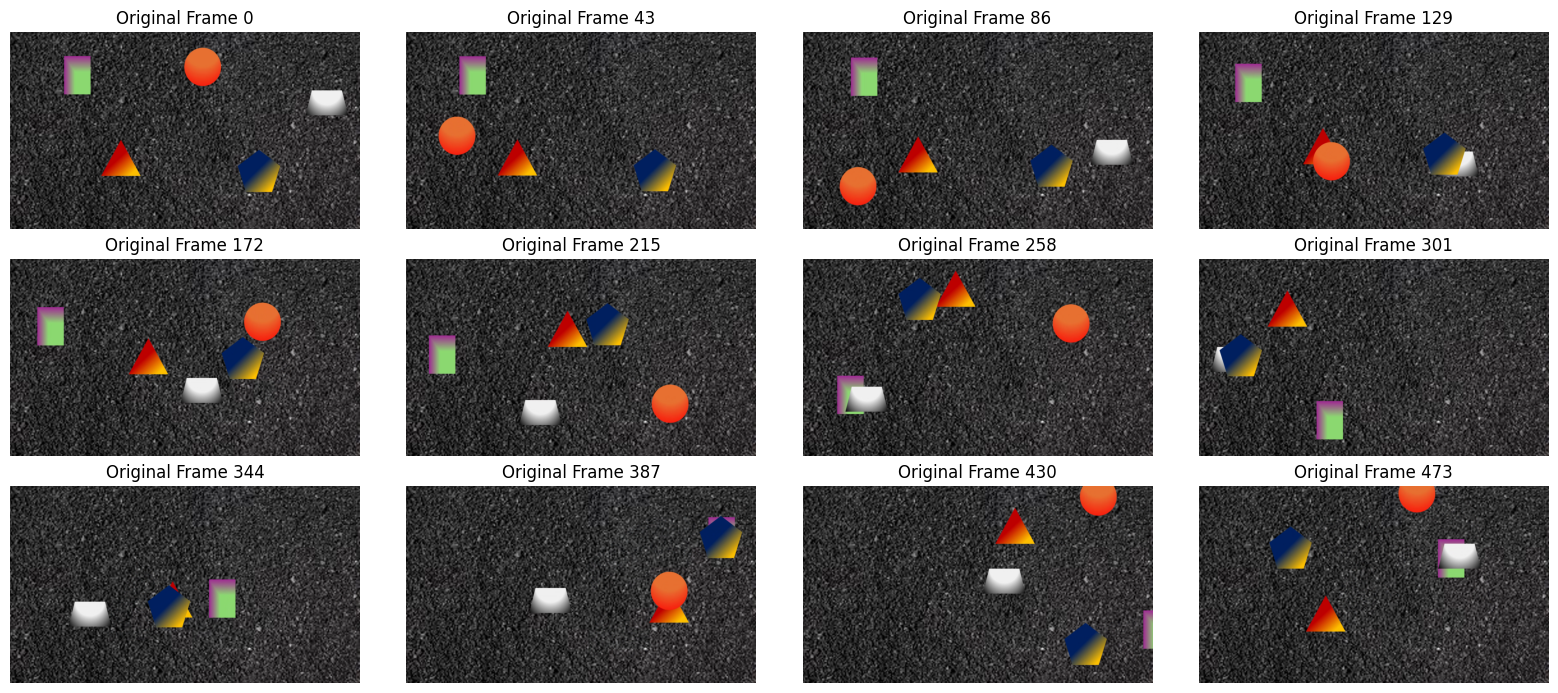

In [4]:
fig, axes = plt.subplots(3, 4, figsize=(16, 7))
axes = axes.flatten()

if len(extracted_frames) == 0:
    print("No frames were extracted to display.")
else:
    for i, frame_bgr in enumerate(extracted_frames):
        if i < len(axes):
            rgb_frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
            axes[i].imshow(rgb_frame)
            axes[i].set_title(f"Original Frame {frame_indices[i]}")
            axes[i].axis('off')

    for j in range(len(extracted_frames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

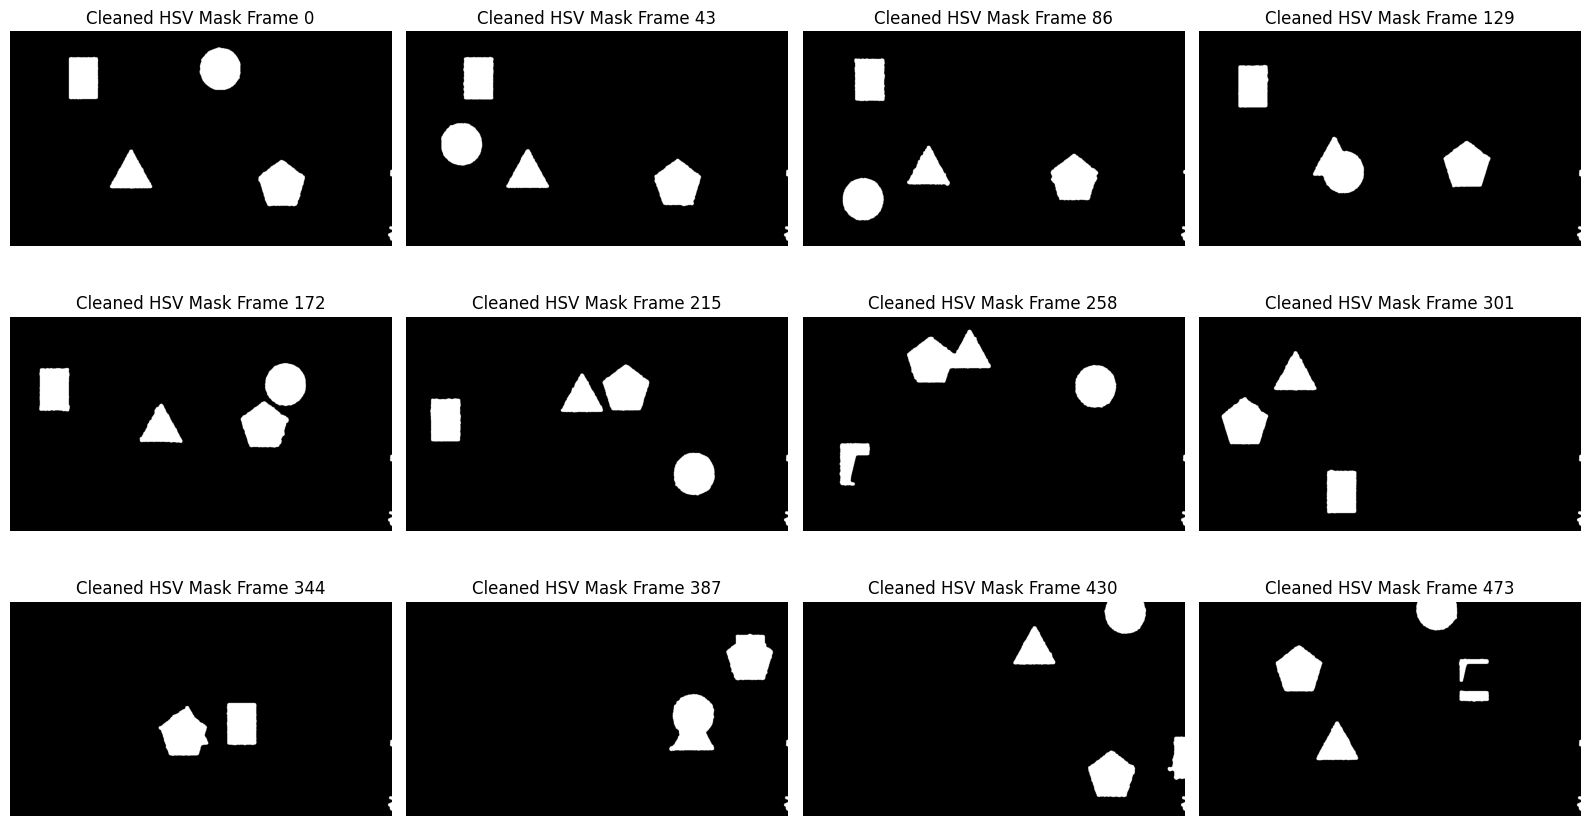

In [82]:
# Define HSV color range (modify as needed)
lower_hsv = np.array([0, 20, 20])
upper_hsv = np.array([255, 255, 255])

fig, axes = plt.subplots(3, 4, figsize=(16, 9))
axes = axes.flatten()

hsv_binaries = []  # Store binary masks for later use

for i, frame_bgr in enumerate(extracted_frames):
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    frame_hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)

    # 1) Create binary mask from HSV range
    hsv_mask = cv2.inRange(frame_hsv, lower_hsv, upper_hsv)

    # 2) Apply Gaussian blur to smooth the mask and reduce noise
    blurred = cv2.GaussianBlur(hsv_mask, (11, 11), 0)

    # 3) Threshold again to get binary mask after blur
    _, clean_mask = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

    # 4) Morphological operations to remove small noise and fill holes
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    hsv_binaries.append(clean_mask)  # Save cleaned binary mask

    axes[i].imshow(clean_mask, cmap='gray')
    axes[i].set_title(f"Cleaned HSV Mask Frame {frame_indices[i]}")
    axes[i].axis('off')

for j in range(len(extracted_frames), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

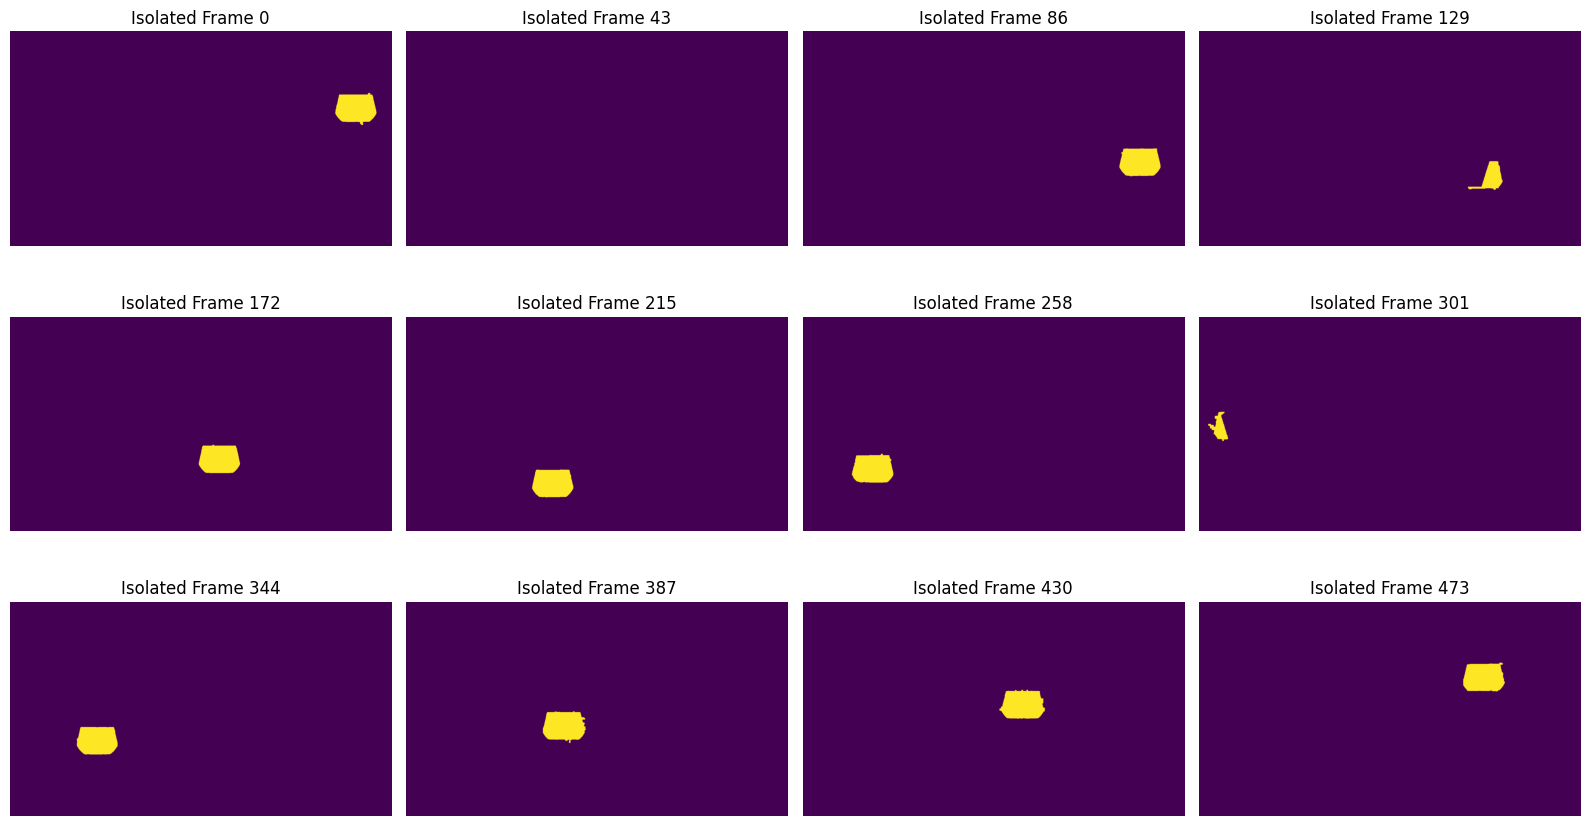

In [96]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Your HSV range - adjust as needed
lower_hsv = np.array([0, 0, 0])
upper_hsv = np.array([255, 5, 255])

final_masks = []

fig, axes = plt.subplots(3, 4, figsize=(16, 9))
axes = axes.flatten()

combined_masks = []

for i, frame_bgr in enumerate(extracted_frames):
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    frame_hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)
    
    # 1) HSV mask
    hsv_mask = cv2.inRange(frame_hsv, lower_hsv, upper_hsv)
    
    # 2) Grayscale + Gaussian blur
    gray = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    # 3) Otsu's threshold
    _, otsu_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 4) Combine masks (AND operation)
    combined_mask = cv2.bitwise_and(hsv_mask, otsu_mask)
    combined_masks.append(combined_mask)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    clean_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        final_mask = np.zeros_like(clean_mask)
        cv2.drawContours(final_mask, [largest_contour], -1, 255, thickness=-1)
    else:
        final_mask = clean_mask

    isolated_trapezoid = cv2.bitwise_and(frame_rgb, frame_rgb, mask=final_mask)

    min_area = 5000
    max_area = 30000
    min_aspect_ratio = 0.5
    max_aspect_ratio = 1.7

    filtered_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            x,y,w,h = cv2.boundingRect(cnt)
            aspect_ratio = w / float(h)
            if min_aspect_ratio < aspect_ratio < max_aspect_ratio:
                filtered_contours.append(cnt)

    if filtered_contours:
        largest_contour = max(filtered_contours, key=cv2.contourArea)
        final_mask = np.zeros_like(clean_mask)
        cv2.drawContours(final_mask, [largest_contour], -1, 255, thickness=-1)
    else:
        final_mask = np.zeros_like(clean_mask)

    final_masks.append(final_mask)

    # Display isolated_trapezoid on axes[i]
    axes[i].imshow(final_mask)
    axes[i].set_title(f"Isolated Frame {frame_indices[i]}")
    axes[i].axis('off')

    # Remove unused subplots if any
    for j in range(len(extracted_frames), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


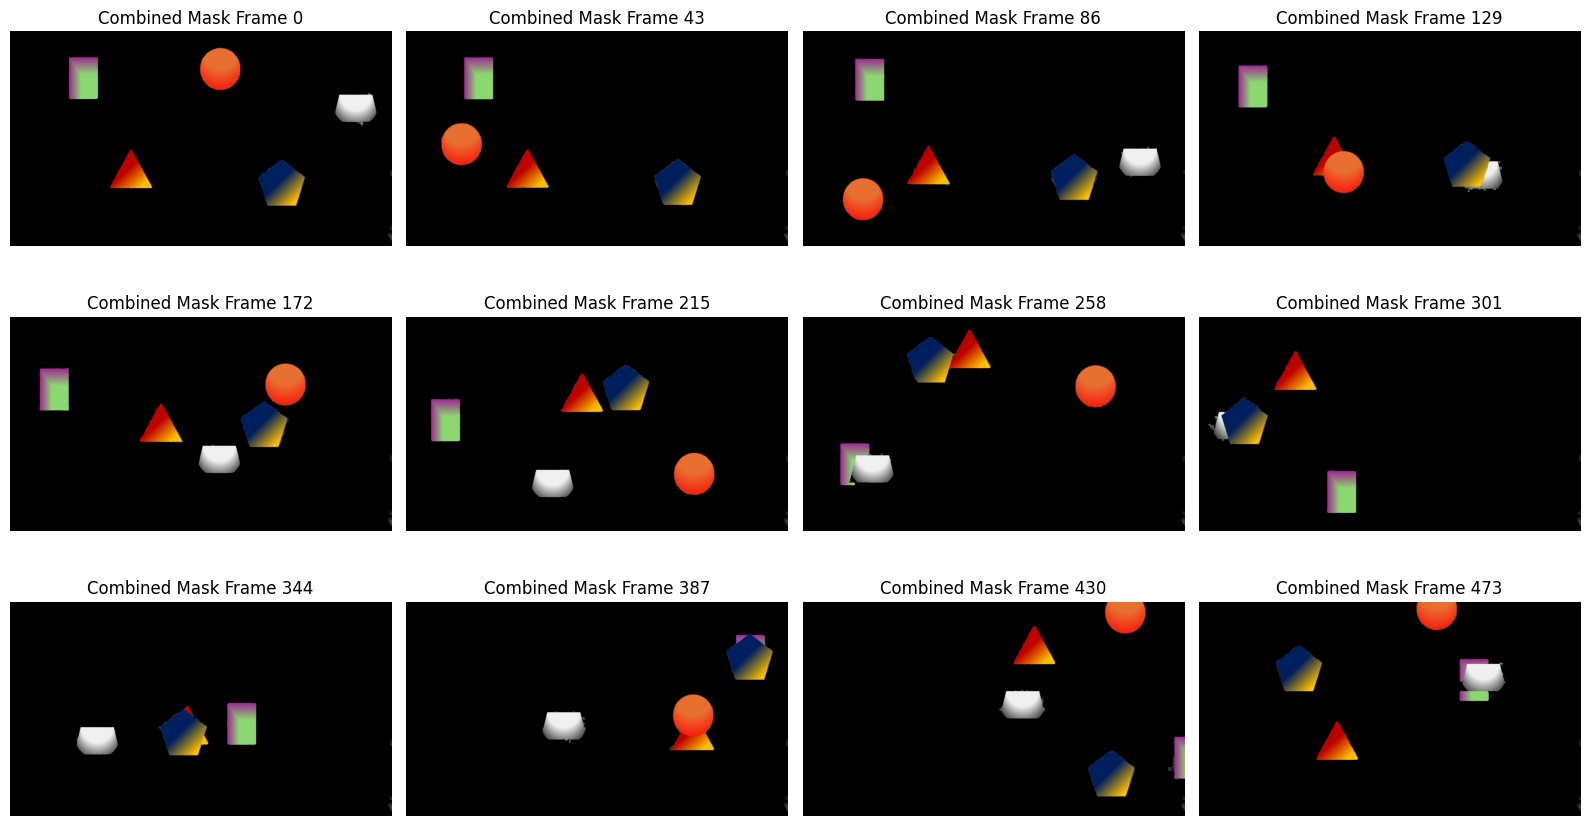

In [92]:
fig, axes = plt.subplots(3, 4, figsize=(16, 9))
axes = axes.flatten()

for i in range(len(extracted_frames)):
    frame_rgb = cv2.cvtColor(extracted_frames[i], cv2.COLOR_BGR2RGB)

    # Combine masks from previous cells:
    union_mask = cv2.bitwise_or(hsv_binaries[i], final_masks[i])

    union_masked_rgb = cv2.bitwise_and(frame_rgb, frame_rgb, mask=union_mask)

    axes[i].imshow(union_masked_rgb)
    axes[i].set_title(f"Combined Mask Frame {frame_indices[i]}")
    axes[i].axis('off')

for j in range(len(extracted_frames), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


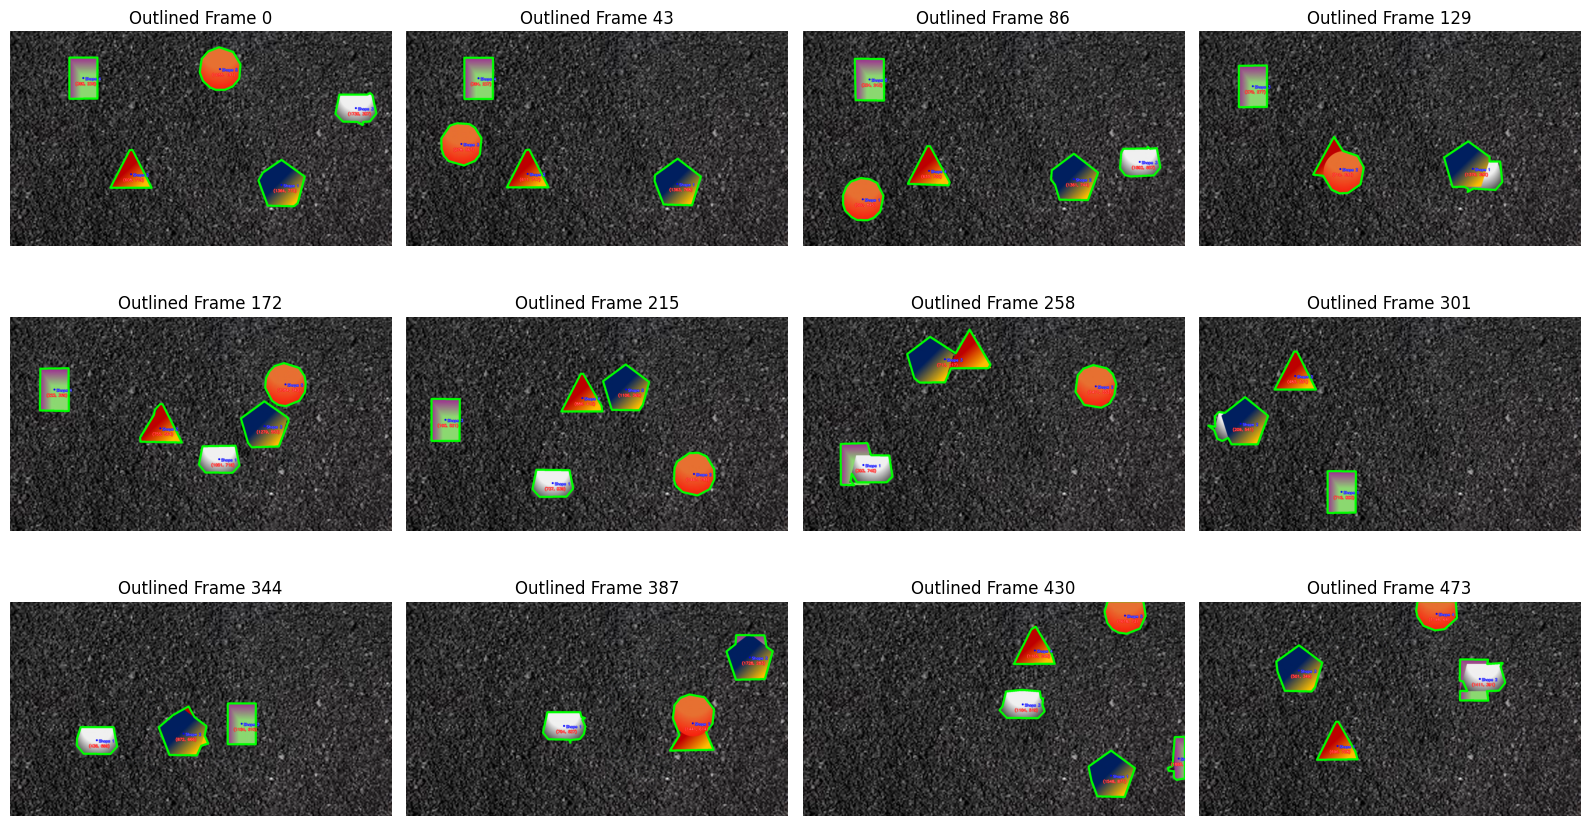

In [95]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Colors for drawing text and circles (BGR)
red = (0, 0, 255)
blue = (255, 0, 0)
white = (255, 255, 255)

fig, axes = plt.subplots(3, 4, figsize=(16, 9))
axes = axes.flatten()

area_threshold = 1000  # minimum contour area to consider

for i in range(len(extracted_frames)):
    frame_bgr = extracted_frames[i]
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    
    # Combine masks from your previous cells
    union_mask = cv2.bitwise_or(hsv_binaries[i], final_masks[i])

    # Find contours on the combined mask
    contours, _ = cv2.findContours(union_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Make a copy of the original image to draw on
    overlay = frame_rgb.copy()

    shape_count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > area_threshold:
            shape_count += 1
            # Approximate contour to reduce number of points
            perimeter = cv2.arcLength(cnt, True)
            epsilon = 0.01 * perimeter
            approx = cv2.approxPolyDP(cnt, epsilon, True)

            # Draw the contour outline (green lines)
            cv2.drawContours(overlay, [approx], -1, (0, 255, 0), 10)

            # Calculate contour center
            M = cv2.moments(approx)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                # Draw center circle
                cv2.circle(overlay, (cX, cY), 5, red, -1)

                # Put text labels: shape number and coordinates with white outline for visibility
                cv2.putText(overlay, f"Shape {shape_count}", (cX + 10, cY + 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, red, 3)
                cv2.putText(overlay, f"Shape {shape_count}", (cX + 10, cY + 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, white, 1)

                coord_text = f"({cX}, {cY})"
                cv2.putText(overlay, coord_text, (cX - 40, cY + 35), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, blue, 3)
                cv2.putText(overlay, coord_text, (cX - 40, cY + 35), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, white, 1)

    axes[i].imshow(overlay)
    axes[i].set_title(f"Outlined Frame {frame_indices[i]}")
    axes[i].axis('off')

# Remove any unused axes (if fewer than 12 frames)
for j in range(len(extracted_frames), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
